# Getting Data and EDA

## Imported necessary libraries and getting first url for API

In [1]:
!pip install matplotlib_venn
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA 
from matplotlib_venn import venn2
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
url='http://strainapi.evanbusse.com/80Bxz5h/strains/search/all'
response=requests.get(url)
dat=response.json()

## Creating Dataframe from API Data

In [2]:
names=list(dat.keys())
positive,negative,medical,posi,neg,med,eff,tye=[],[],[],[],[],[],[],[]
for n in names:
    tye.append(dat[n]['race'])
    eff.append(dat[n]['effects']['positive']+dat[n]['effects']['negative']+dat[n]['effects']['medical'])
    positive.append(dat[n]['effects']['positive'])
    posi.append(len(dat[n]['effects']['positive']))
    negative.append(dat[n]['effects']['negative'])
    neg.append(len(dat[n]['effects']['negative']))
    medical.append(dat[n]['effects']['medical'])
    med.append(len(dat[n]['effects']['medical']))
dic={'name':names,'type':tye,'effects':eff}
df=pd.DataFrame(dic)
df.head()

,name,type,effects
0,Afpak,hybrid,"[Relaxed, Hungry, Happy, Sleepy, Dizzy, Depres..."
1,African,sativa,"[Euphoric, Happy, Creative, Energetic, Talkati..."
2,Afternoon Delight,hybrid,"[Relaxed, Hungry, Euphoric, Uplifted, Tingly, ..."
3,Afwreck,hybrid,"[Relaxed, Happy, Creative, Uplifted, Sleepy, D..."
4,Agent Orange,hybrid,"[Relaxed, Euphoric, Happy, Energetic, Uplifted..."


## Cleaning up dataframe, creating dummy columns for all effects

In [3]:
effects=[]
pos=list(eff)
for p in pos:
    for i in p:
        if i not in effects:
            effects.append(i)
for i in effects:
    title=str(i)
    title=[]
    for x in df['effects']:
        if i in x:
            title.append(1)
        else:
            title.append(0)
    df[i]=title

## Getting Dummies for Type (0: Indica, 1: Sativa, 2: Hybrid)

### Engineer features for positive effect score, negative effect score, and medical effect score

In [4]:
df.drop(columns='effects',inplace=True)
df.type=df.type.map({'indica':0,'sativa':1,'hybrid':2})
lowers=[]
for n in df['name']:
    lowers.append(n.lower())
df['name']=lowers
df['positive']=posi
df['negative']=neg
df['medical']=med

## Visualizing Indica, Sativa, and Hybrid. Describes what a Hybrid Strain Is

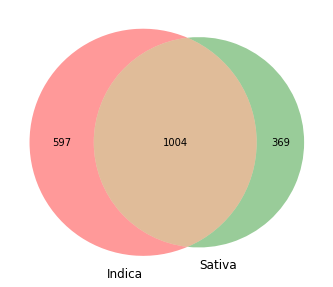

In [5]:
plt.figure(figsize=(10,5))
venn2(subsets=(len(df[df['type']==0]),len(df[df['type']==1]),len(df[df['type']==2])),set_labels=('Indica','Sativa'))
plt.savefig('VennDiagram_Indica_Sativa')

## Scraping THC Content

In [6]:
namelist=[]
# typelist=[]
thclist=[]
for i in range(1,62):
    response=requests.get('https://www.wikileaf.com/strains/?page={}'.format(i))
    soup=BeautifulSoup(response.content,'html.parser')
    names=soup.findAll('h5',{'class':'name disp-title'})
#     types=soup.findAll('p',{'class':'tag'})
    thcs=soup.findAll('p',{'class':'desc'})
    for n,x in zip(names,thcs):
        namelist.append(n.text.lower())
#         typelist.append(t.text.lower())
        thclist.append(int(x.text[3:6].strip('%')))
effects.append('thc')

## Finalizing DataFrame with all Effects

In [7]:
moreinfo={'name':namelist,'thc':thclist}
df3=pd.DataFrame(moreinfo)
fulldf=pd.merge(df,df3,on='name')
# fulldf.sort_values('thc',inplace=True)
fulldf.reset_index(inplace=True)
fulldf.drop(columns='index',inplace=True)
fulldf.head()

,name,type,Relaxed,Hungry,Happy,Sleepy,Dizzy,Depression,Insomnia,Pain,...,Anxious,Giggly,Aroused,Inflammation,Spasticity,Seizures,positive,negative,medical,thc
0,african,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,5,1,6,10
1,afternoon delight,2,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,5,3,6,18
2,afwreck,2,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,5,4,6,26
3,agent orange,2,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,5,4,6,15
4,agent tangie,2,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,5,2,5,18


## Checking How THC Content Varies with Type

<Figure size 720x360 with 0 Axes>

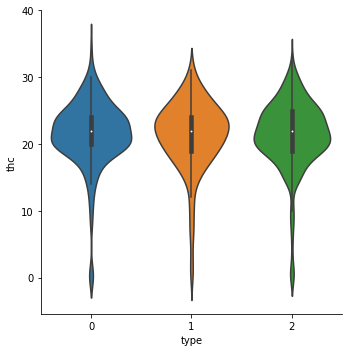

In [8]:
plt.figure(figsize=(10,5))
sns.catplot(x='type',y='thc',kind='violin',data=fulldf)
plt.savefig('ViolinPlots.png')

### Examining different kinds of effects v. thc content

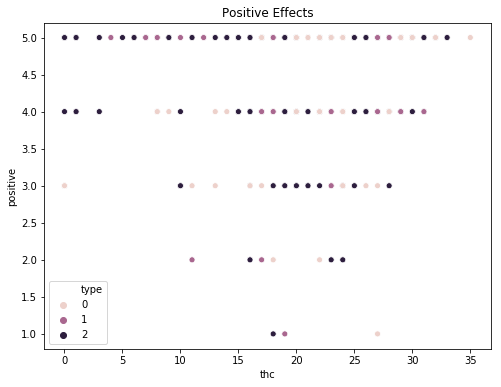

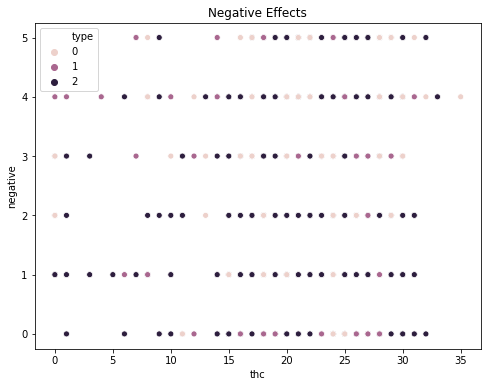

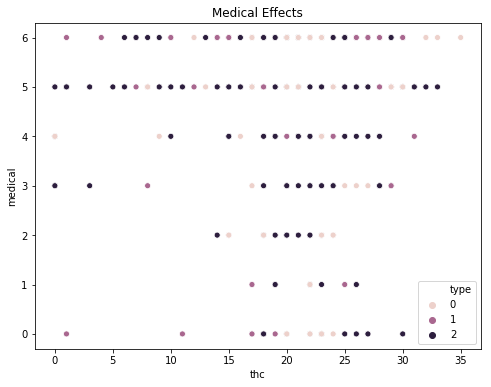

In [9]:
plt.figure(figsize=(8,6))
plt.title('Positive Effects')
sns.scatterplot(x='thc',y='positive',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Negative Effects')
sns.scatterplot(x='thc',y='negative',hue='type',data=fulldf)
plt.figure(figsize=(8,6))
plt.title('Medical Effects')
sns.scatterplot(x='thc',y='medical',hue='type',data=fulldf)

## Checking for Class Imbalance

Probability of Indica: 0.2823871906841339
Probability of Sativa: 0.19796215429403202
Probability of Hybrid: 0.519650655021834


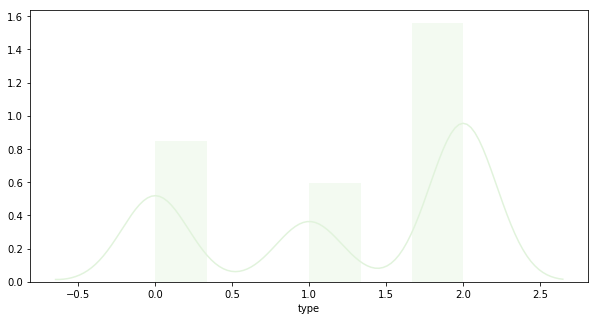

In [10]:
indicadf=fulldf[fulldf['type']==0]
sativadf=fulldf[fulldf['type']==1]
hybriddf=fulldf[fulldf['type']==2]

sns.set_palette("Greens")
plt.figure(figsize=(10,5))
sns.distplot(fulldf['type'])
prind=len(indicadf)/len(fulldf)
prsat=len(sativadf)/len(fulldf)
prhyb=len(hybriddf)/len(fulldf)
print('Probability of Indica: {}'.format(prind))
print('Probability of Sativa: {}'.format(prsat))
print('Probability of Hybrid: {}'.format(prhyb))
plt.savefig('TargetDistplots.png', bbox_inches='tight')

## Looking for Important Features: Feature Selection By Hand

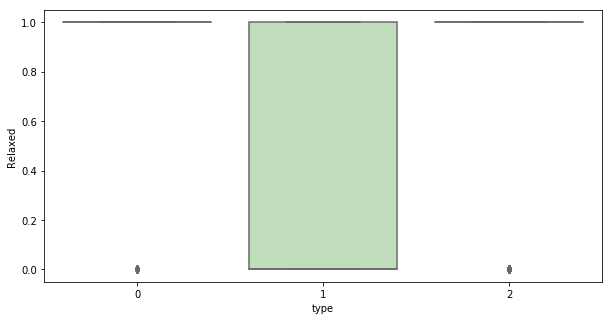

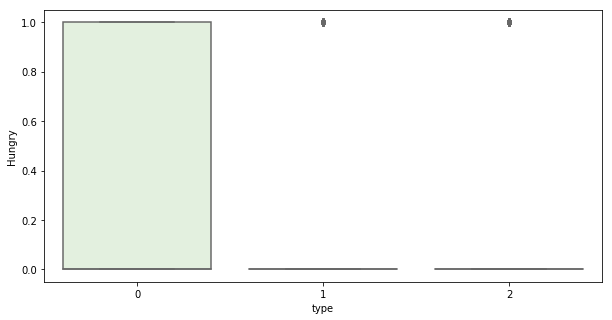

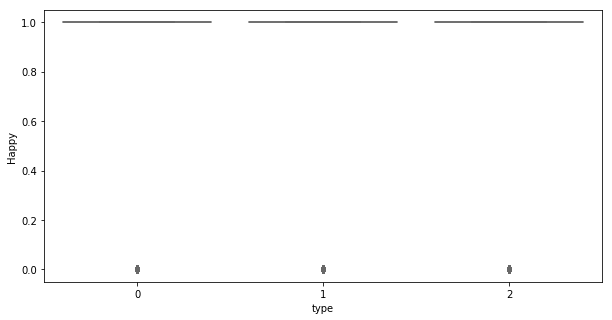

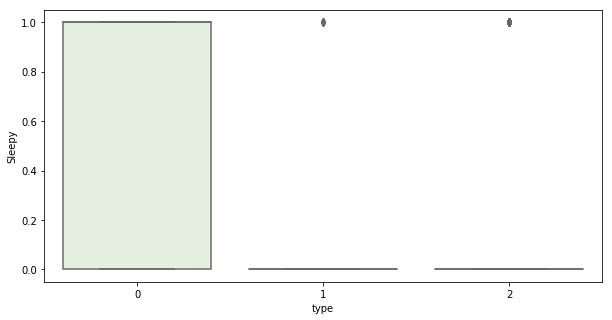

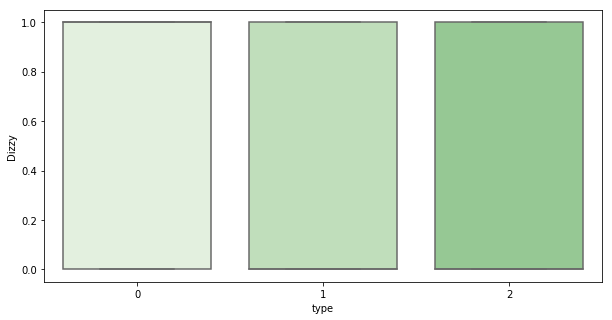

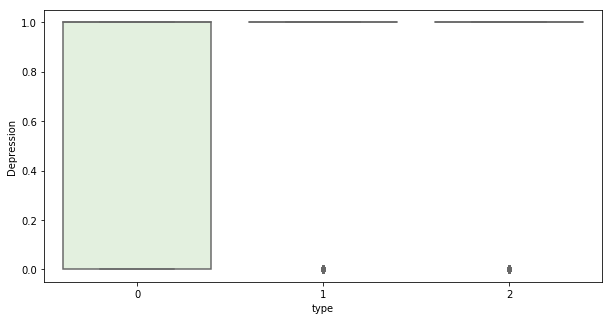

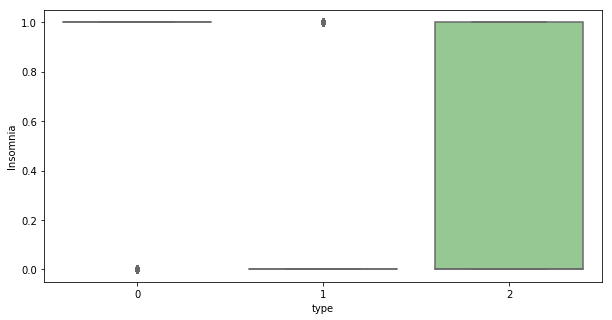

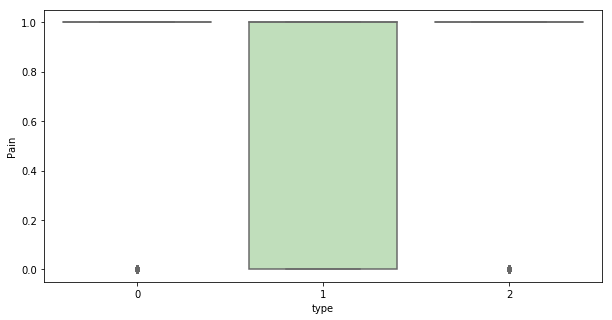

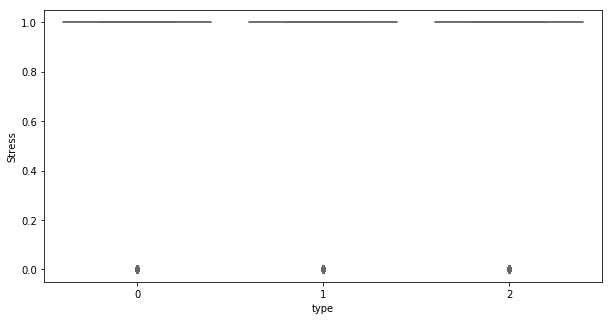

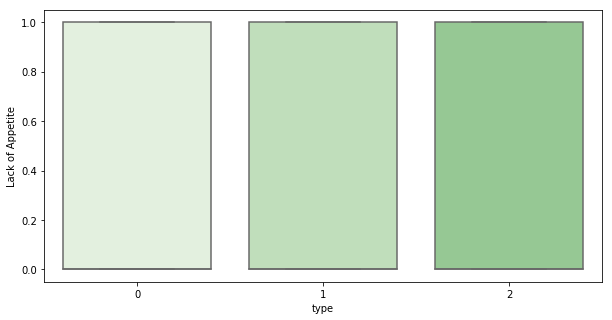

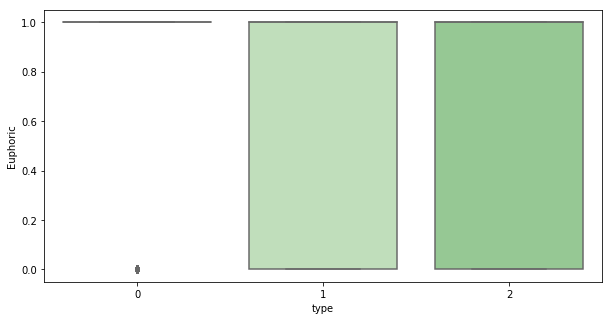

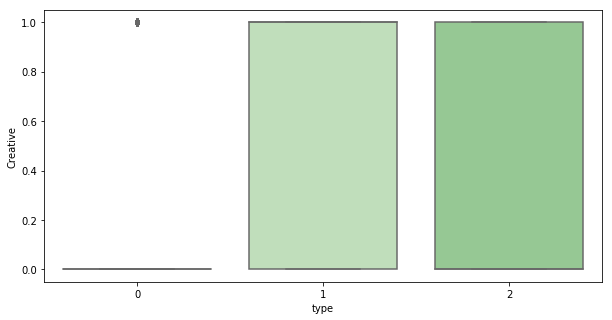

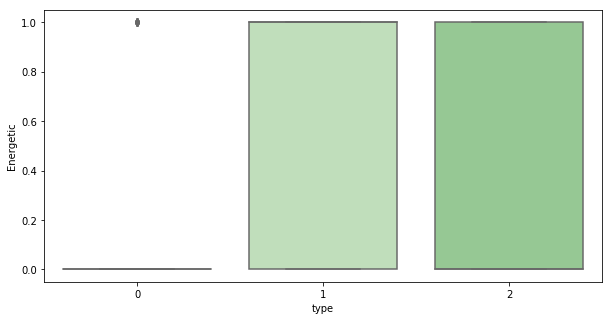

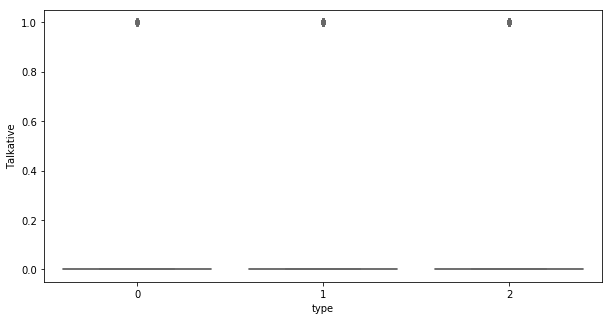

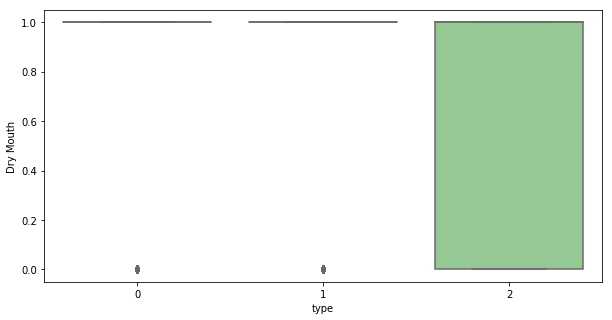

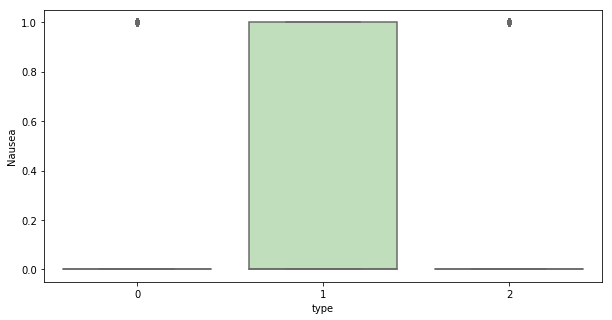

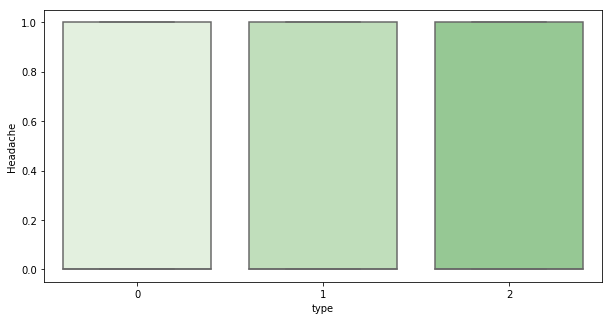

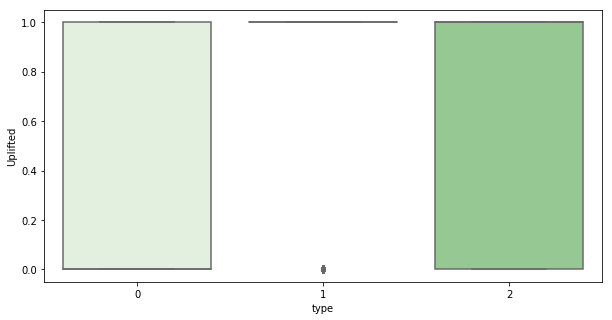

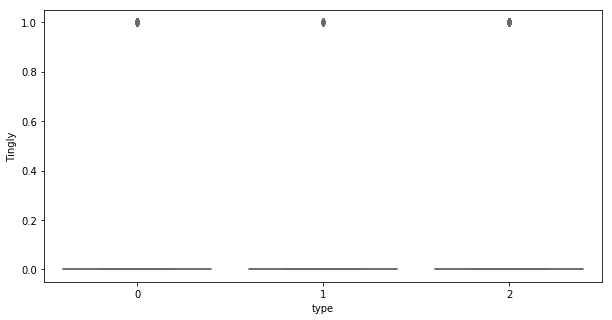

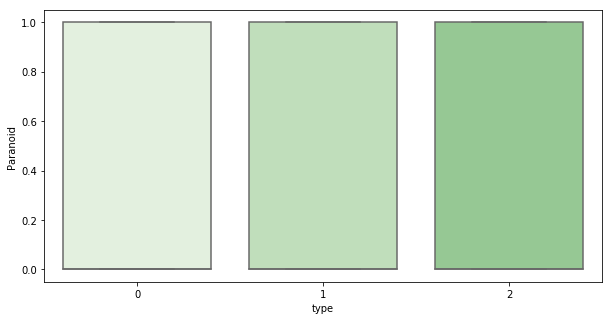

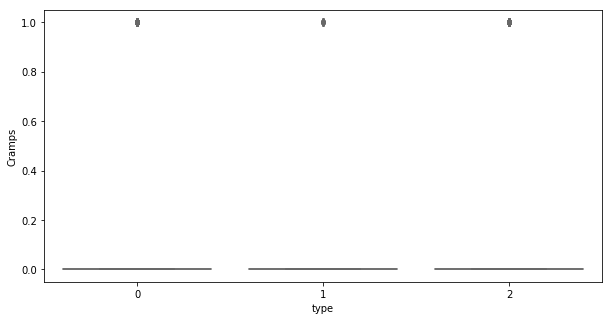

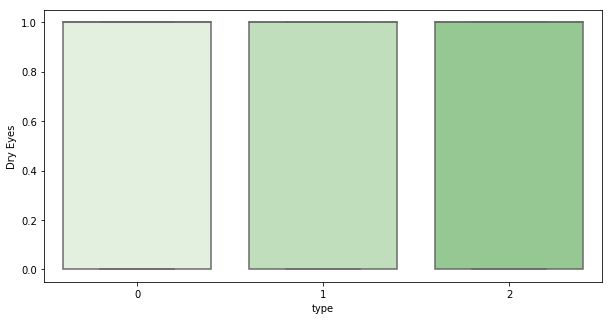

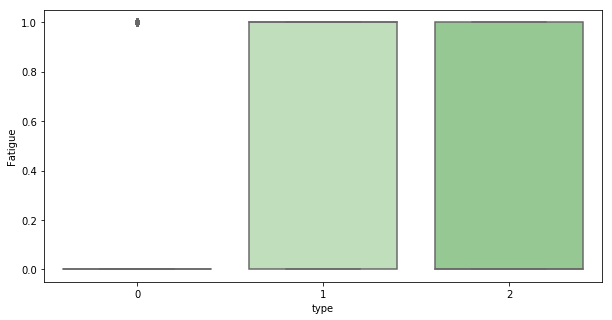

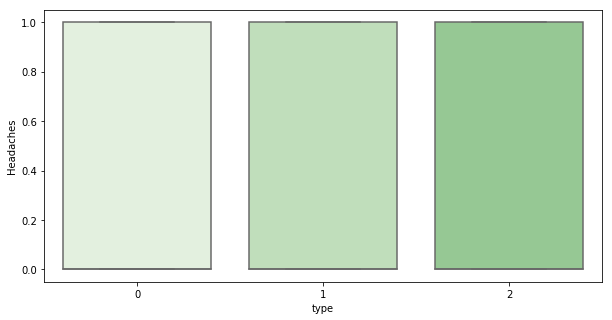

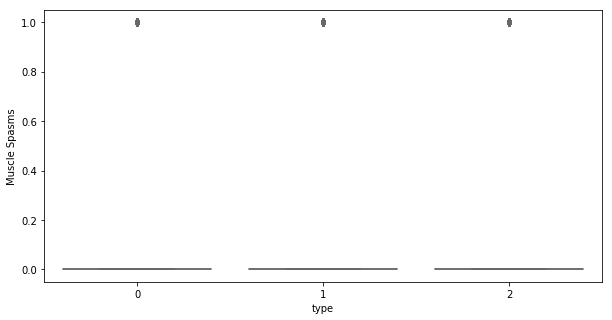

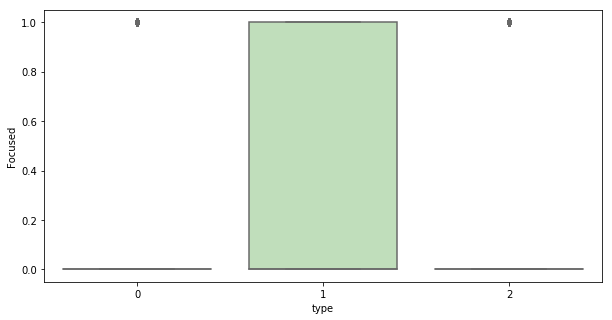

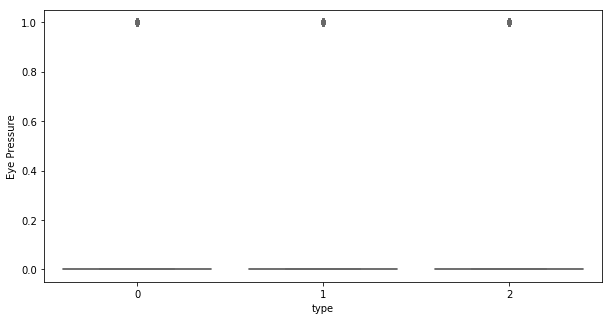

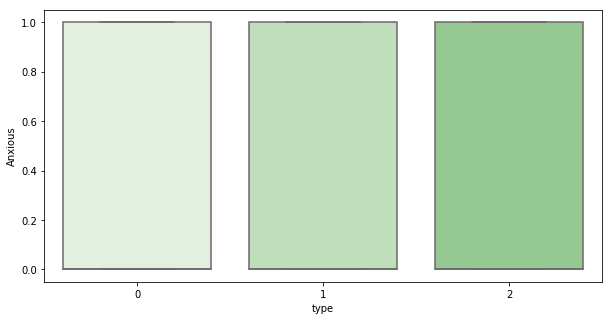

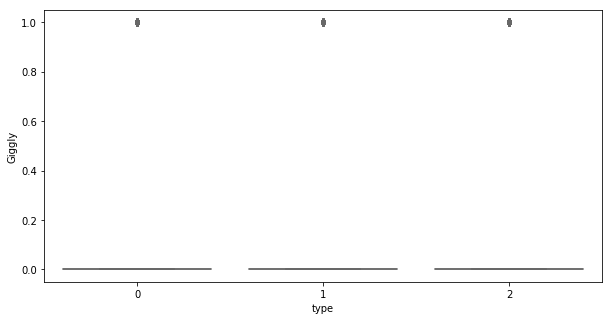

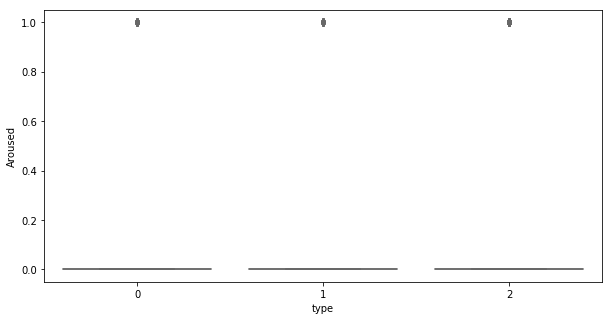

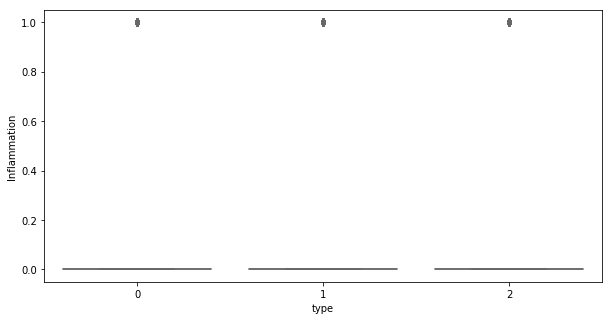

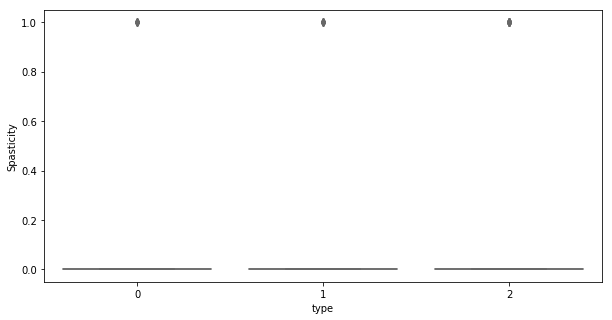

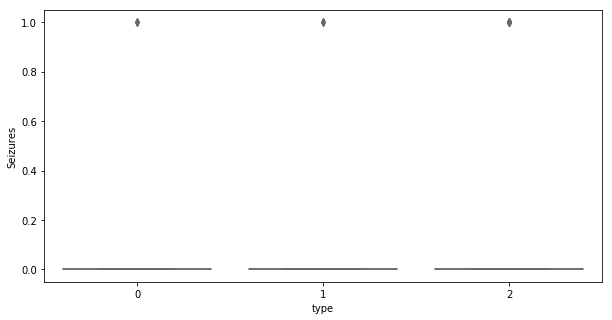

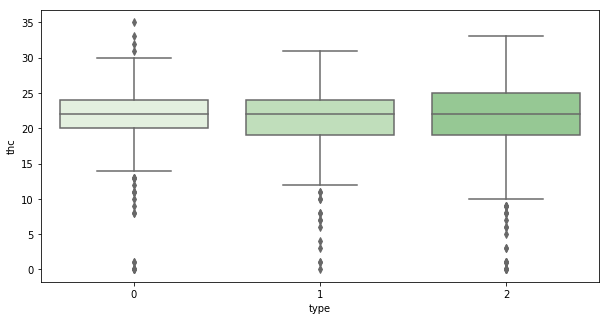

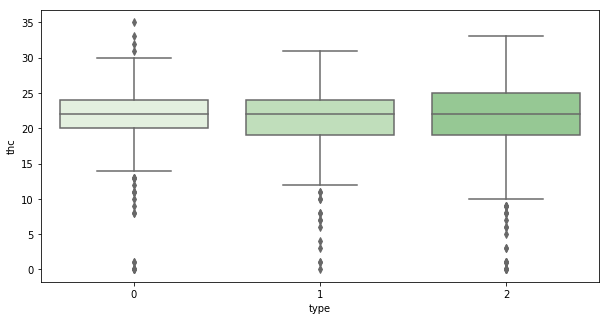

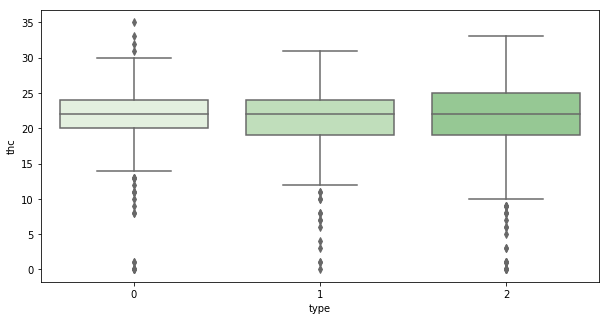

In [12]:
effects.append('thc')
for e in effects:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='type',y=e,data=fulldf)
    plt.savefig('{}.png'.format(e),bbox_inches='tight')
# sns.scatterplot(sativadf['Relaxed'])
# sns.scatterplot(hybriddf['Relaxed'])

In [13]:
with open('df.pickle','wb') as f:
    pickle.dump(fulldf,f,pickle.HIGHEST_PROTOCOL)

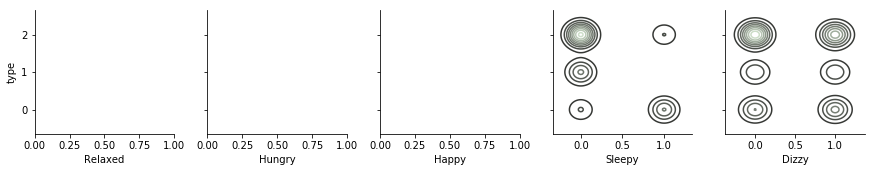

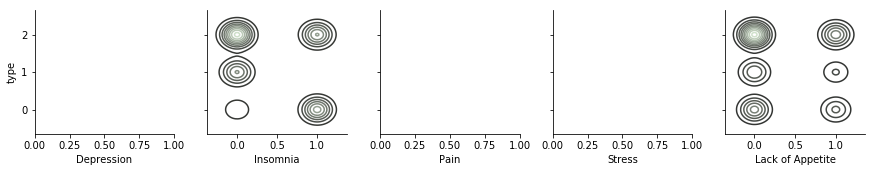

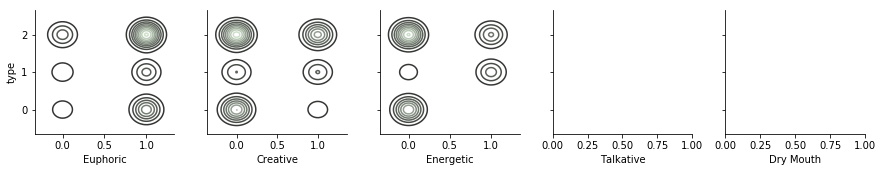

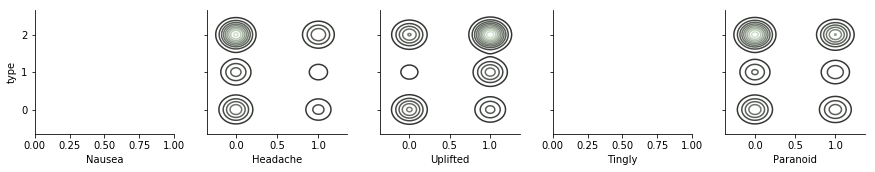

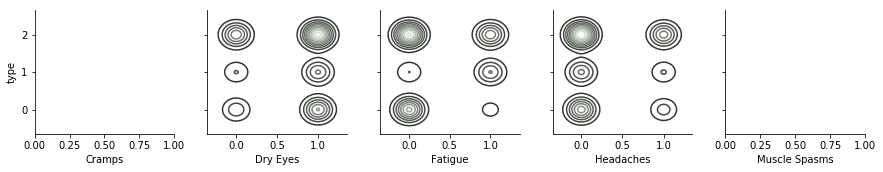

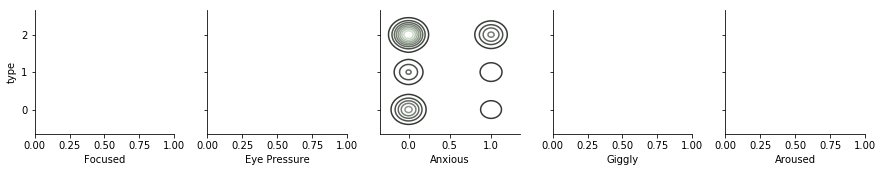

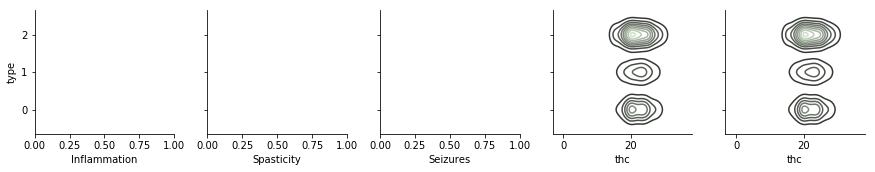

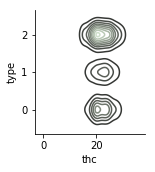

In [14]:
for i in range(0, 38, 5):
    g = sns.PairGrid(fulldf,
                     x_vars = effects[i:i+5],
                     y_vars = ['type'])
    g = g.map(sns.kdeplot)

NameError: name 'scaleddf' is not defined